In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet


In [5]:

file_path = '/content/sample_data/Kemondo_Sales_final.xlsx'
df_daily = pd.read_excel(file_path)

In [6]:


# 80-20 split
split_index = int(len(df_daily) * 0.8)
train_daily = df_daily[:split_index].copy()
test_daily = df_daily[split_index:].copy()

print(f"\nTraining set: {len(train_daily)} observations")
print(f"Test set: {len(test_daily)} observations")



Training set: 1055 observations
Test set: 264 observations


In [8]:
# Naive forecast
naive_forecast_daily = np.full(len(test_daily), train_daily['Sales'].iloc[-1])

# Calculating metrics
naive_mae_daily = mean_absolute_error(test_daily['Sales'], naive_forecast_daily)
naive_rmse_daily = np.sqrt(mean_squared_error(test_daily['Sales'], naive_forecast_daily))
naive_r2_daily = r2_score(test_daily['Sales'], naive_forecast_daily)
naive_mape_daily = mean_absolute_percentage_error(test_daily['Sales'], naive_forecast_daily) * 100

print("=== Naive Forecast Performance (Daily) ===")
print(f"MAE: {naive_mae_daily:,.2f}")
print(f"RMSE: {naive_rmse_daily:,.2f}")
print(f"R²: {naive_r2_daily:.4f}")
print(f"MAPE: {naive_mape_daily:.2f}%")


=== Naive Forecast Performance (Daily) ===
MAE: 272,866.81
RMSE: 438,526.61
R²: -0.3238
MAPE: 45.98%


In [9]:
# Fitting SARIMA model for daily data
# (1,1,1)x(1,1,1,7) for daily data with weekly seasonality
try:
    sarima_model_daily = SARIMAX(train_daily['Sales'],
                                 order=(1, 1, 1),
                                 seasonal_order=(1, 1, 1, 7),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
    sarima_fit_daily = sarima_model_daily.fit(disp=False, maxiter=200)

    # Forecast
    sarima_forecast_daily = sarima_fit_daily.forecast(steps=len(test_daily))

    # Calculate metrics
    sarima_mae_daily = mean_absolute_error(test_daily['Sales'], sarima_forecast_daily)
    sarima_rmse_daily = np.sqrt(mean_squared_error(test_daily['Sales'], sarima_forecast_daily))
    sarima_r2_daily = r2_score(test_daily['Sales'], sarima_forecast_daily)
    sarima_mape_daily = mean_absolute_percentage_error(test_daily['Sales'], sarima_forecast_daily) * 100

    print("\n=== SARIMA Performance (Daily) ===")
    print(f"MAE: {sarima_mae_daily:,.2f}")
    print(f"RMSE: {sarima_rmse_daily:,.2f}")
    print(f"R²: {sarima_r2_daily:.4f}")
    print(f"MAPE: {sarima_mape_daily:.2f}%")
    sarima_success_daily = True
except Exception as e:
    print(f"\nSARIMA Error (Daily): {e}")
    sarima_success_daily = False



=== SARIMA Performance (Daily) ===
MAE: 265,721.24
RMSE: 408,712.03
R²: -0.1499
MAPE: 55.75%


In [10]:
# Fitting Holt-Winters model for daily data
# Using seasonal_periods=7 for weekly seasonality
try:
    hw_model_daily = ExponentialSmoothing(train_daily['Sales'],
                                         seasonal_periods=7,
                                         trend='add',
                                         seasonal='add')
    hw_fit_daily = hw_model_daily.fit()

    # Forecasting
    hw_forecast_daily = hw_fit_daily.forecast(steps=len(test_daily))

    # Calculating metrics
    hw_mae_daily = mean_absolute_error(test_daily['Sales'], hw_forecast_daily)
    hw_rmse_daily = np.sqrt(mean_squared_error(test_daily['Sales'], hw_forecast_daily))
    hw_r2_daily = r2_score(test_daily['Sales'], hw_forecast_daily)
    hw_mape_daily = mean_absolute_percentage_error(test_daily['Sales'], hw_forecast_daily) * 100

    print("\n=== Holt-Winters Performance (Daily) ===")
    print(f"MAE: {hw_mae_daily:,.2f}")
    print(f"RMSE: {hw_rmse_daily:,.2f}")
    print(f"R²: {hw_r2_daily:.4f}")
    print(f"MAPE: {hw_mape_daily:.2f}%")
    hw_success_daily = True
except Exception as e:
    print(f"\nHolt-Winters Error (Daily): {e}")
    hw_success_daily = False



=== Holt-Winters Performance (Daily) ===
MAE: 261,719.10
RMSE: 398,413.78
R²: -0.0927
MAPE: 56.88%


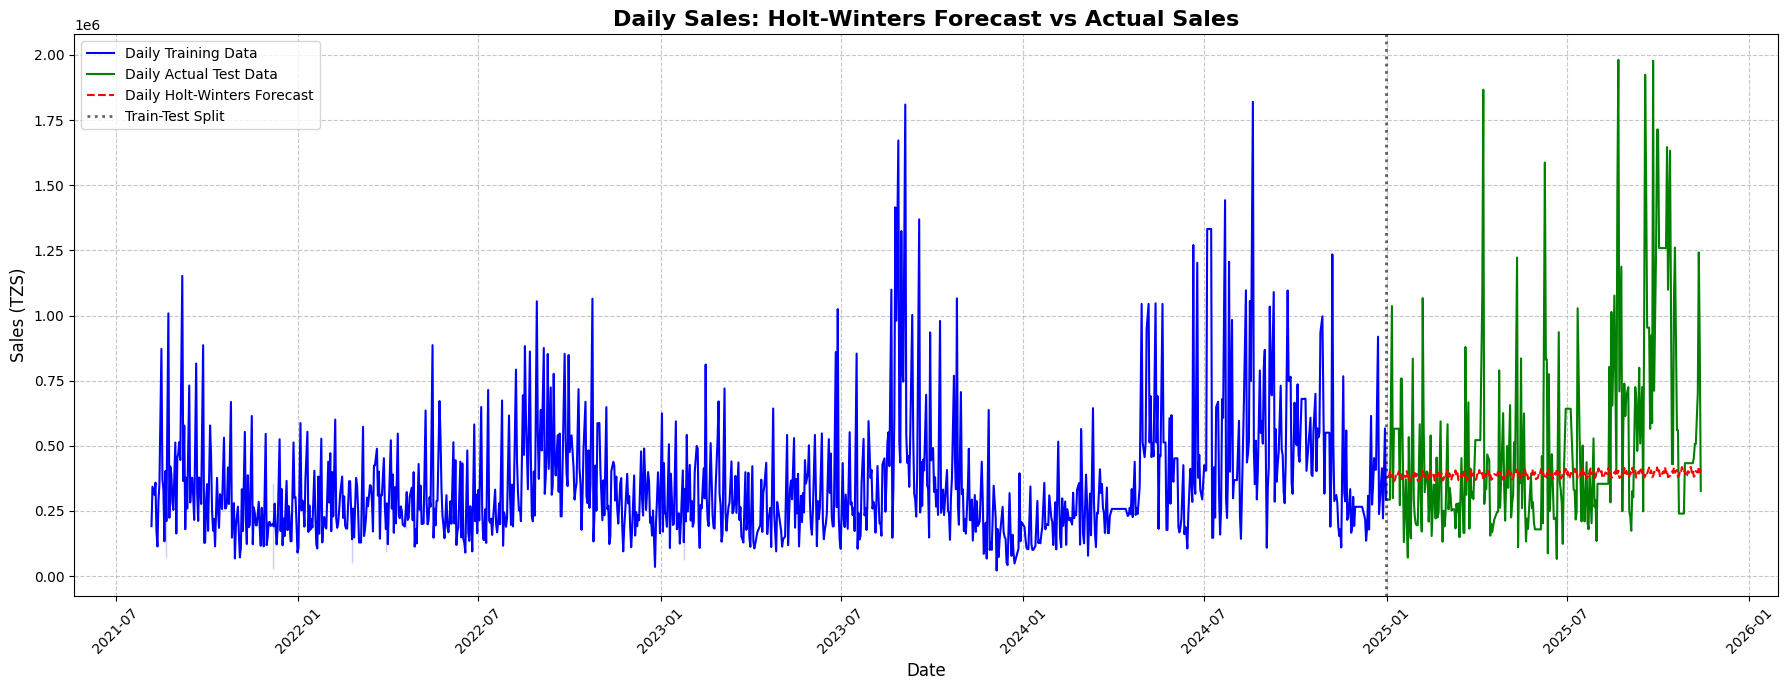

In [ ]:
# Preparing data for plotting Holt-Winters
test_hw_plot = test_daily[['Date', 'Sales']].copy()
test_hw_plot['Actual'] = test_hw_plot['Sales']
test_hw_plot['HW_Forecast'] = hw_forecast_daily.values

# Plotting Daily Holt-Winters Forecast
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=train_daily, label='Daily Training Data', color='blue')
sns.lineplot(x='Date', y='Actual', data=test_hw_plot, label='Daily Actual Test Data', color='green')
sns.lineplot(x='Date', y='HW_Forecast', data=test_hw_plot, label='Daily Holt-Winters Forecast', color='red', linestyle='--')
plt.axvline(x=train_daily['Date'].iloc[-1], color='black', linestyle=':', linewidth=2, label='Train-Test Split', alpha=0.6)
plt.title('Daily Sales: Holt-Winters Forecast vs Actual Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales (TZS)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# Preparing data for Prophet
train_prophet_daily = train_daily[['Date', 'Sales']].copy()
train_prophet_daily.columns = ['ds', 'y']

# Fitting Prophet model
try:
    prophet_model_daily = Prophet(yearly_seasonality=True,
                                  weekly_seasonality=True,
                                  daily_seasonality=False)
    prophet_model_daily.fit(train_prophet_daily)

    # Create future dataframe
    future_daily = pd.DataFrame({'ds': test_daily['Date']})
    prophet_forecast_daily = prophet_model_daily.predict(future_daily)

    # Extract predictions
    prophet_pred_daily = prophet_forecast_daily['yhat'].values

    # Calculate metrics
    prophet_mae_daily = mean_absolute_error(test_daily['Sales'], prophet_pred_daily)
    prophet_rmse_daily = np.sqrt(mean_squared_error(test_daily['Sales'], prophet_pred_daily))
    prophet_r2_daily = r2_score(test_daily['Sales'], prophet_pred_daily)
    prophet_mape_daily = mean_absolute_percentage_error(test_daily['Sales'], prophet_pred_daily) * 100

    print("\n=== Prophet Performance (Daily) ===")
    print(f"MAE: {prophet_mae_daily:,.2f}")
    print(f"RMSE: {prophet_rmse_daily:,.2f}")
    print(f"R²: {prophet_r2_daily:.4f}")
    print(f"MAPE: {prophet_mape_daily:.2f}%")
    prophet_success_daily = True
except Exception as e:
    print(f"\nProphet Error (Daily): {e}")
    prophet_success_daily = False



=== Prophet Performance (Daily) ===
MAE: 269,612.14
RMSE: 350,456.88
R²: 0.1545
MAPE: 76.46%


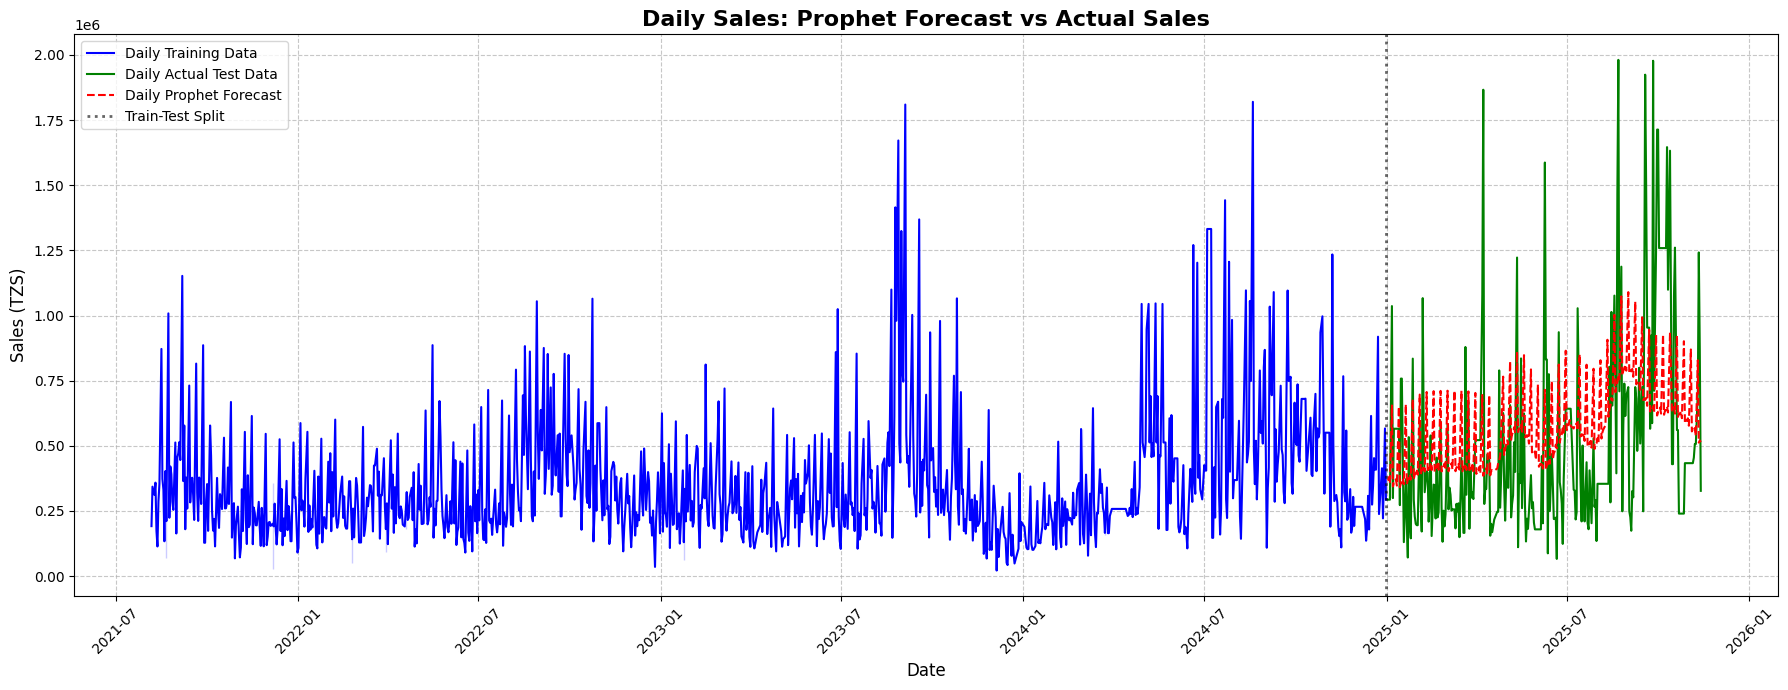

In [ ]:
# Preparing data for plotting Prophet
train_prophet_plot = train_prophet_daily.copy()
train_prophet_plot.columns = ['Date', 'Sales']

test_prophet_plot = test_daily[['Date', 'Sales']].copy()
test_prophet_plot['Actual'] = test_prophet_plot['Sales']
test_prophet_plot['Prophet_Forecast'] = prophet_pred_daily

# Plotting Daily Prophet Forecast
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=train_prophet_plot, label='Daily Training Data', color='blue')
sns.lineplot(x='Date', y='Actual', data=test_prophet_plot, label='Daily Actual Test Data', color='green')
sns.lineplot(x='Date', y='Prophet_Forecast', data=test_prophet_plot, label='Daily Prophet Forecast', color='red', linestyle='--')
plt.axvline(x=train_daily['Date'].iloc[-1], color='black', linestyle=':', linewidth=2, label='Train-Test Split', alpha=0.6)
plt.title('Daily Sales: Prophet Forecast vs Actual Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales (TZS)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [13]:
# Feature engineering for daily Random Forest
def create_daily_features(df):
    df = df.copy()
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.isocalendar().week
    df['month'] = df['Date'].dt.month
    df['quarter'] = df['Date'].dt.quarter
    df['year'] = df['Date'].dt.year

    # Cyclical encoding for weekly seasonality
    df['week_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['week_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Cyclical encoding for monthly seasonality
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Peak season
    df['peak_season'] = ((df['month'] >= 8) & (df['month'] <= 10)).astype(int)

    # Lag features
    df['sales_lag_1'] = df['Sales'].shift(1)
    df['sales_lag_7'] = df['Sales'].shift(7)
    df['sales_lag_14'] = df['Sales'].shift(14)
    df['sales_lag_30'] = df['Sales'].shift(30)

    # Rolling statistics
    df['sales_rolling_mean_7'] = df['Sales'].rolling(window=7, min_periods=1).mean()
    df['sales_rolling_std_7'] = df['Sales'].rolling(window=7, min_periods=1).std()
    df['sales_rolling_mean_30'] = df['Sales'].rolling(window=30, min_periods=1).mean()

    # Trend
    df['time_index'] = np.arange(len(df))

    return df

# Apply features
df_rf_daily = create_daily_features(df_daily)

# Split
train_rf_daily = df_rf_daily[:split_index].dropna().copy()
test_rf_daily = df_rf_daily[split_index:].dropna().copy()

# Define features
feature_cols_daily = ['dayofweek', 'dayofmonth', 'weekofyear', 'month', 'quarter',
                      'week_sin', 'week_cos', 'month_sin', 'month_cos',
                      'peak_season', 'time_index',
                      'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30',
                      'sales_rolling_mean_7', 'sales_rolling_std_7', 'sales_rolling_mean_30']

X_train_daily = train_rf_daily[feature_cols_daily]
y_train_daily = train_rf_daily['Sales']
X_test_daily = test_rf_daily[feature_cols_daily]
y_test_daily = test_rf_daily['Sales']

# Train Random Forest
rf_model_daily = RandomForestRegressor(n_estimators=200,
                                      max_depth=15,
                                      min_samples_split=5,
                                      min_samples_leaf=2,
                                      random_state=42,
                                      n_jobs=-1)
rf_model_daily.fit(X_train_daily, y_train_daily)

# Forecast
rf_forecast_daily = rf_model_daily.predict(X_test_daily)

# Calculate metrics
rf_mae_daily = mean_absolute_error(y_test_daily, rf_forecast_daily)
rf_rmse_daily = np.sqrt(mean_squared_error(y_test_daily, rf_forecast_daily))
rf_r2_daily = r2_score(y_test_daily, rf_forecast_daily)
rf_mape_daily = mean_absolute_percentage_error(y_test_daily, rf_forecast_daily) * 100

print("\n=== Random Forest Performance (Daily) ===")
print(f"MAE: {rf_mae_daily:,.2f}")
print(f"RMSE: {rf_rmse_daily:,.2f}")
print(f"R²: {rf_r2_daily:.4f}")
print(f"MAPE: {rf_mape_daily:.2f}%")



=== Random Forest Performance (Daily) ===
MAE: 198,616.85
RMSE: 314,036.83
R²: 0.3211
MAPE: 44.89%


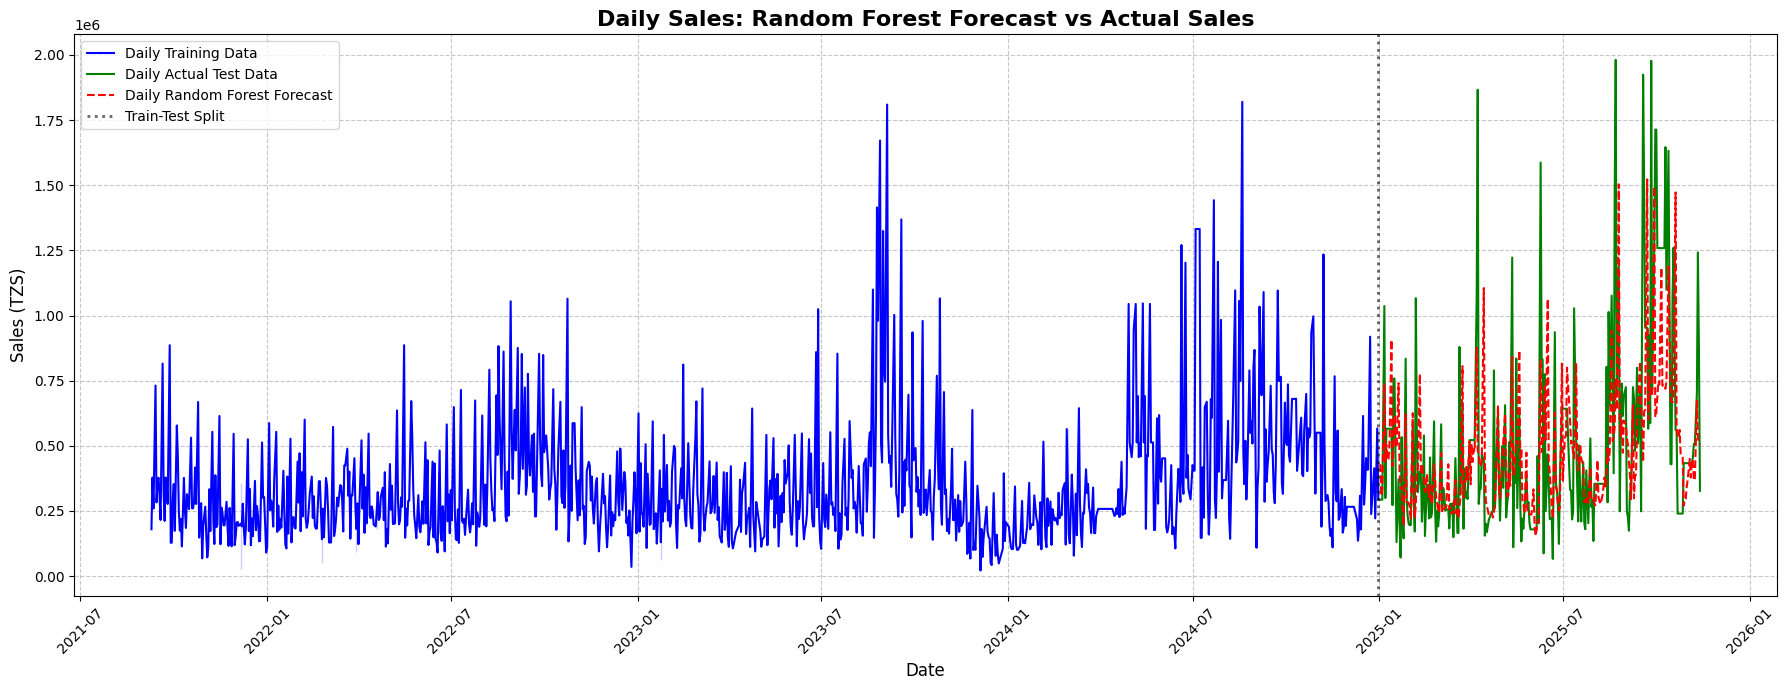

In [14]:
# Preparing data for plotting
train_daily_plot = train_rf_daily[['Date', 'Sales']].copy()
test_daily_plot = test_rf_daily[['Date', 'Sales']].copy()
test_daily_plot['Actual'] = test_daily_plot['Sales']
test_daily_plot['RF_Forecast'] = rf_forecast_daily

# Plotting Daily Random Forest Forecast
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=train_daily_plot, label='Daily Training Data', color='blue')
sns.lineplot(x='Date', y='Actual', data=test_daily_plot, label='Daily Actual Test Data', color='green')
sns.lineplot(x='Date', y='RF_Forecast', data=test_daily_plot, label='Daily Random Forest Forecast', color='red', linestyle='--')
plt.axvline(x=train_rf_daily['Date'].iloc[-1], color='black', linestyle=':', linewidth=2, label='Train-Test Split', alpha=0.6)
plt.title('Daily Sales: Random Forest Forecast vs Actual Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales (TZS)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
# Creating comparison dataframe
results_daily = pd.DataFrame({
    'Model': ['Naive', 'SARIMA', 'Holt-Winters', 'Prophet', 'Random Forest'],
    'MAE': [
        naive_mae_daily,
        sarima_mae_daily if 'sarima_success_daily' in locals() and sarima_success_daily else np.nan,
        hw_mae_daily if 'hw_success_daily' in locals() and hw_success_daily else np.nan,
        prophet_mae_daily if 'prophet_success_daily' in locals() and prophet_success_daily else np.nan,
        rf_mae_daily
    ],
    'RMSE': [
        naive_rmse_daily,
        sarima_rmse_daily if 'sarima_success_daily' in locals() and sarima_success_daily else np.nan,
        hw_rmse_daily if 'hw_success_daily' in locals() and hw_success_daily else np.nan,
        prophet_rmse_daily if 'prophet_success_daily' in locals() and prophet_success_daily else np.nan,
        rf_rmse_daily
    ]
})

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON - DAILY SALES")
print("="*80)
print(results_daily.to_string(index=False))
print("="*80)

# Identify best model for each metric
print("\nBest Models (Daily):")
valid_mae = results_daily.dropna(subset=['MAE'])
valid_rmse = results_daily.dropna(subset=['RMSE'])


if not valid_mae.empty:
    print(f"Lowest MAE: {valid_mae.loc[valid_mae['MAE'].idxmin(), 'Model']} ({valid_mae['MAE'].min():,.2f})")
if not valid_rmse.empty:
    print(f"Lowest RMSE: {valid_rmse.loc[valid_rmse['RMSE'].idxmin(), 'Model']} ({valid_rmse['RMSE'].min():,.2f})")




MODEL PERFORMANCE COMPARISON - DAILY SALES
        Model           MAE          RMSE
        Naive 272866.806590 438526.610235
       SARIMA 265721.244727 408712.025766
 Holt-Winters 261719.098047 398413.778785
      Prophet 269612.135937 350456.877500
Random Forest 198616.849679 314036.830219

Best Models (Daily):
Lowest MAE: Random Forest (198,616.85)
Lowest RMSE: Random Forest (314,036.83)
